In [82]:
import pickle
import gzip
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet201, DenseNet121, DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, classification_report
import numpy as np

In [15]:
with open('/kaggle/input/preprocessed-data/preprocessed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

In [16]:
X = loaded_data['data']
y = loaded_data['labels']

In [17]:
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=26)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.15,
                                                    stratify=y,
                                                    random_state=42)

**DenseNet201 With the Last 20 Layers Unfrozen**

In [19]:
checkpoint_cb = ModelCheckpoint('checkpoints', save_best_only=True,
                                save_weights_only=True, verbose=1)
reduce_lr_cb = ReduceLROnPlateau(patience=10,verbose=1)
early_stopping_cb = EarlyStopping(patience=30, 
                                  restore_best_weights=True,
                                  start_from_epoch=20,
                                  verbose=1)

In [62]:
base_model = DenseNet201(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:
    layer.trainable = True
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(26, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
history = model.fit(x_train, y_train, epochs=1000, 
                    validation_split=0.2, 
                    callbacks=[checkpoint_cb, reduce_lr_cb, early_stopping_cb])

Epoch 1/1000
34/34 [==============================] - ETA: 0s - loss: 3.5875 - accuracy: 0.0736
Epoch 1: val_loss did not improve from 0.28678
34/34 [==============================] - 25s 296ms/step - loss: 3.5875 - accuracy: 0.0736 - val_loss: 3.3641 - val_accuracy: 0.1128 - lr: 0.0010
Epoch 2/1000
33/34 [============================>.] - ETA: 0s - loss: 3.2018 - accuracy: 0.1212
Epoch 2: val_loss did not improve from 0.28678
34/34 [==============================] - 6s 182ms/step - loss: 3.2018 - accuracy: 0.1208 - val_loss: 3.2619 - val_accuracy: 0.0639 - lr: 0.0010
Epoch 3/1000
33/34 [============================>.] - ETA: 0s - loss: 2.8825 - accuracy: 0.1780
Epoch 3: val_loss did not improve from 0.28678
34/34 [==============================] - 6s 183ms/step - loss: 2.8812 - accuracy: 0.1783 - val_loss: 3.9684 - val_accuracy: 0.0639 - lr: 0.0010
Epoch 4/1000
33/34 [============================>.] - ETA: 0s - loss: 2.5891 - accuracy: 0.2689
Epoch 4: val_loss did not improve from 0.2

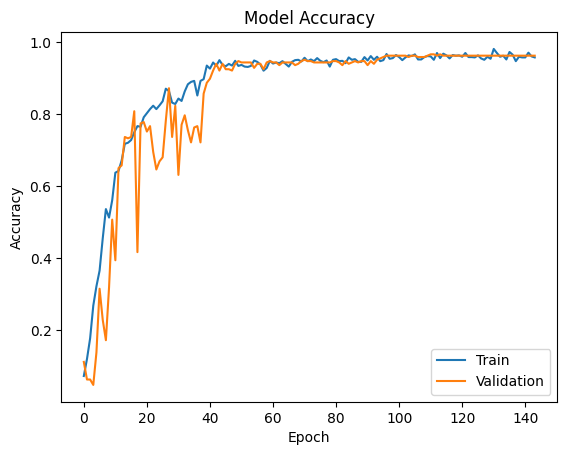

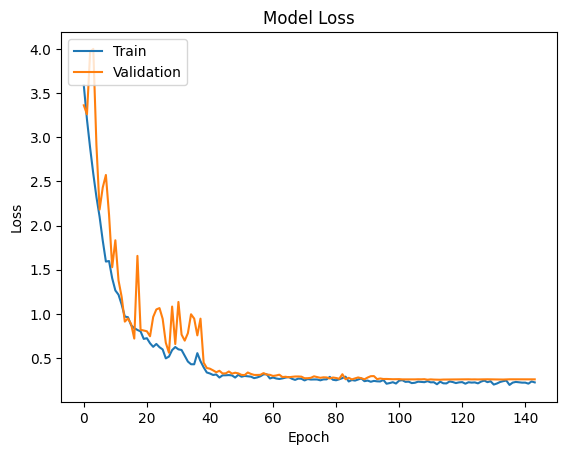

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluate the Model**

In [65]:
class_names = [chr(i) for i in range(65, 91)]  # generate a list of uppercase English letters

In [67]:
model.evaluate(x_train, y_train)

42/42 [==============================] - 6s 143ms/step - loss: 0.1160 - accuracy: 0.9925


[0.11595217138528824, 0.9924585223197937]

42/42 [==============================] - 9s 141ms/step


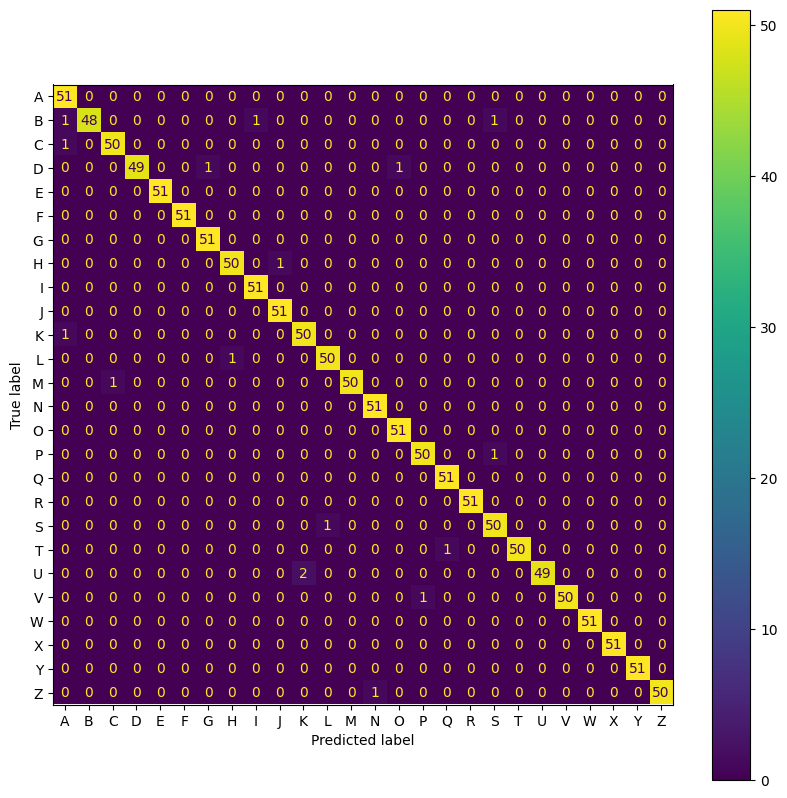

In [66]:
y_pred_probs_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_probs, axis=1)
y_true_train = np.argmax(y_train, axis=1)  # Assuming y_train is one-hot encoded
cm = confusion_matrix(y_true_train, y_pred_train)

fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax)
plt.show()

In [73]:
precision = precision_score(y_true_train, y_pred_train, average='macro')
print('Training precision: %.3f' % precision)

Training precision: 0.987


In [74]:
recall = recall_score(y_true_train, y_pred_train, average='macro')
print('Training recall: %.3f' % recall)

Training recall: 0.987


In [84]:
report = classification_report(y_true_train, y_pred_train, target_names=class_names)

print(report)

              precision    recall  f1-score   support

           A       0.94      1.00      0.97        51
           B       1.00      0.94      0.97        51
           C       0.98      0.98      0.98        51
           D       1.00      0.96      0.98        51
           E       1.00      1.00      1.00        51
           F       1.00      1.00      1.00        51
           G       0.98      1.00      0.99        51
           H       0.98      0.98      0.98        51
           I       0.98      1.00      0.99        51
           J       0.98      1.00      0.99        51
           K       0.96      0.98      0.97        51
           L       0.98      0.98      0.98        51
           M       1.00      0.98      0.99        51
           N       0.98      1.00      0.99        51
           O       0.98      1.00      0.99        51
           P       0.98      0.98      0.98        51
           Q       0.98      1.00      0.99        51
           R       1.00    

In [68]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 130ms/step - loss: 0.2510 - accuracy: 0.9487


[0.25095129013061523, 0.9487179517745972]

8/8 [==============================] - 1s 145ms/step


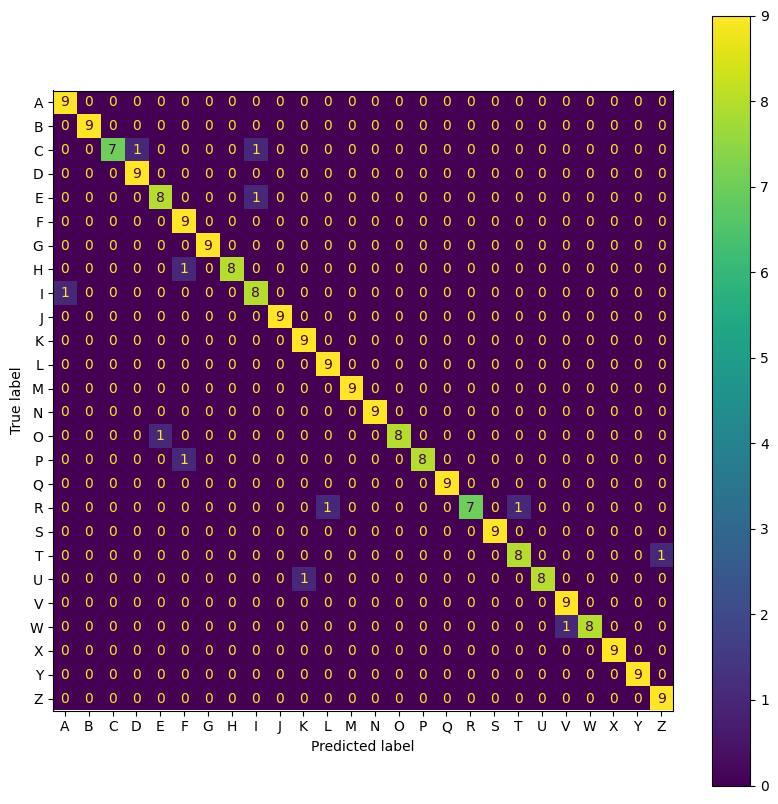

In [69]:
y_pred_probs_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_probs_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)  # y_test is one-hot encoded

cm = confusion_matrix(y_true_test, y_pred_test)

fig, ax = plt.subplots(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax) 
plt.show()

In [75]:
precision = precision_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % precision)

Test precision: 0.954


In [76]:
recall = recall_score(y_true_test, y_pred_test, average='macro')
print('Test precision: %.3f' % recall)

Test precision: 0.949


In [83]:
report = classification_report(y_true_test, y_pred_test, target_names=class_names)

print(report)

              precision    recall  f1-score   support

           A       0.90      1.00      0.95         9
           B       1.00      1.00      1.00         9
           C       1.00      0.78      0.88         9
           D       0.90      1.00      0.95         9
           E       0.89      0.89      0.89         9
           F       0.82      1.00      0.90         9
           G       1.00      1.00      1.00         9
           H       1.00      0.89      0.94         9
           I       0.80      0.89      0.84         9
           J       1.00      1.00      1.00         9
           K       0.90      1.00      0.95         9
           L       0.90      1.00      0.95         9
           M       1.00      1.00      1.00         9
           N       1.00      1.00      1.00         9
           O       1.00      0.89      0.94         9
           P       1.00      0.89      0.94         9
           Q       1.00      1.00      1.00         9
           R       1.00    

**ٍSave the Model**

In [85]:
model.save('final_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
